In [302]:
!pwd

/content


In [303]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
import torch.functional as F
from torchvision.models import vgg19
from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline


vgg19_model = vgg19(pretrained=True)

class Extract_Features_Model(nn.Module):
    def __init__(self):
        super(Extract_Features_Model, self).__init__()
        self.chosen_layer = ["0",'5', '10', '19', '28']
        self.model = vgg19_model.features[:29]
    
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            if(str(layer_num) in self.chosen_layer):
                features.append(x)
        
        return features
    

def load_image(img, transform, shape=None, max_size=None):
    if type(img) == str:
        img = cv2.imread(img)
    else:
        img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = img.astype(np.float32)
    
    if max_size:
      scale = max_size / max(img.shape)
      size = np.array((img.shape[1], img.shape[0])) * scale
      img = cv2.resize(img, size.astype(int))

    
    if shape:
      img = cv2.resize(img, shape)
    plt.imshow(img)
    plt.show()
    if transform:
        img = transform(img)
    img = img.unsqueeze(0)
    return img

In [304]:
content_img_pth = "./em.jpg"
style_img_pth = "./sunflower3.jpg"

origin_shape = cv2.imread(content_img_pth).shape
init_image = np.random.random_sample(origin_shape)


(1280, 960, 3)

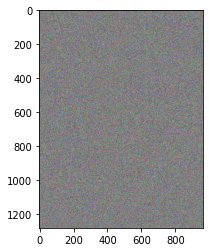

In [305]:
plt.imshow(init_image)
origin_shape

In [306]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))
])

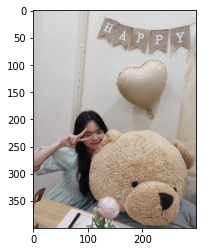

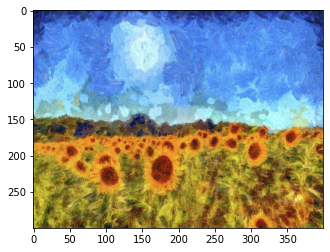

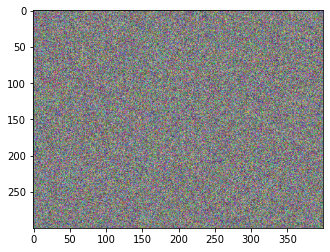

In [307]:
content_image = load_image(content_img_pth, transform, max_size=400)
style_image = load_image(style_img_pth, transform, shape = [content_image.size(2), content_image.size(3)])

init_image = load_image(init_image, transform, shape = [content_image.size(2), content_image.size(3)])
init_image = content_image.clone().requires_grad_(True)

In [308]:
init_image.shape

torch.Size([1, 3, 400, 300])

## Model setup

In [309]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [310]:
model = Extract_Features_Model().to(device).eval()

In [311]:
summary(model, (3,300,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

## Hyper parameters


In [312]:
alpha = 1
beta = 1000
lr = 1e-3
epochs = 6000

In [313]:
optimizer = Adam([init_image], lr=lr,betas=[0.5, 0.999])

## Training

In [ ]:
for epoch in range(epochs):

    content_features = model(content_image.to(device))
    init_img_features = model(init_image.to(device))
    style_features = model(style_image.to(device))
    
    style_loss = content_loss = 0
    
    # content, style, init
    for con, sty, ini in zip(content_features, style_features, init_img_features):
        
        # Calc content loss
        content_loss += torch.mean((con - ini)**2)
        
        # Calc style loss
        # Reshape convolutional features map to list of channels
        _, c, h, w = ini.size()
    
        
        # Gram matrix
        G = torch.mm(ini.view(c, h*w), ini.view(c, h*w).t())
        A = torch.mm(sty.view(c, h*w), sty.view(c, h*w).t())
        
        style_loss += torch.mean((G-A)**2)/(c*h*w)
    
    loss = content_loss + beta * style_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
      print(f"Content loss: {content_loss.item():.4f}, Style loss: {style_loss.item():.4f}")

    if (epoch+1) % 1000 == 0:
      denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
      img = init_image.clone().squeeze()
      img = denorm(img).clamp_(0, 1)
      torchvision.utils.save_image(img, 'output-{}.png'.format(epoch+1))
    
        

Content loss: 50.3553, Style loss: 219.5320
